In [1]:
from pykalman import KalmanFilter
import h5py
import numpy as np
from moseq2_detectron_extract.io.annot import default_keypoint_names
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
import statsmodels.api as sm
import math
import seaborn as sns
from sklearn.decomposition import PCA, FastICA
from moseq2_detectron_extract.proc.kalman import KalmanTracker2

def plot_coords(x, y):
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(24, 5))
    axs[0].plot(x)
    axs[0].set_ylabel('X position')
    axs[1].plot(y)
    axs[1].set_ylabel('Y position')
    axs[1].set_xlabel('Frame #')
    return fig, axs

def plot_coords_2d(x, y, z=None, use_z=True, zlabel="Frame #", figsize=None, ax=None, cmap="plasma"):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    else:
        fig = None
    if z is None:
        z = np.arange(x.shape[0])
    if use_z:
        plot_color_line(ax, x, y, z, zlabel=zlabel, cmap=cmap)
    else:
        ax.plot(x, y, c='k', linestyle='dashed')
    ax.set_ylabel('Y position')
    ax.set_xlabel('X position')
    return fig, ax

def plot_color_line(ax, x, y, z, cmap="plasma", zlabel="Frame #"):
    """ Plots a line that varies in color according to `z` and `cmap` 

    Parameters:
        ax (matplotlib axis instance): Axis to plot on
        x (numpy array-like): x data
        y (numpy array-like): y data
        z (numpy array-like): z data (used for color)
        cmap (colormap): Colormap instance or color map name
        zlabel (string): label for colorbar
    """
    #cmap = plt.get_cmap(cmap)
    if np.nanmin(z) < 0 and np.nanmax(z) > 0:
        norm = mcolors.CenteredNorm(vcenter=0)
    else:
        norm = plt.Normalize()

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(z)
    lc.set_linewidth(1.2)
    ax.add_collection(lc)

    min_value = min([np.nanmin(x), np.nanmin(y)])
    max_value = max([np.nanmax(x), np.nanmax(y)])

    ax.set_xlim(min_value, max_value)
    ax.set_ylim(min_value, max_value)
    ax.set_aspect('equal')
    ax.set_anchor('C')

    axcb = plt.colorbar(lc)
    axcb.set_label(zlabel)

    return
#end plot_color_line()

def calc_keypoint_dist(frames):
    '''
    Parameters:
    frames (np.ndarray): keypoint data for a single frame, of shape (nframes, nkeypoints, 2 [x, y])
    '''
    dist = np.ndarray((frames.shape[0], frames.shape[1], frames.shape[1]), dtype=float)
    for f in range(frames.shape[0]):
        for i in range(frames.shape[1]):
            for j in range(frames.shape[1]):
                dist[f, i, j] = math.sqrt( ((frames[f, i, 0]-frames[f, j, 0])**2) + ((frames[f, i, 1]-frames[f, j, 1])**2) )
    return dist

In [2]:
#dataset_path = r"D:\moseq-extract-testing\test_2animal_full_timecourse\20MOS08-F\session_20201026124130\proc_5k\results_00.h5"
dataset_path = r"C:\Users\Josh\Downloads\results_00.h5"

In [3]:

with h5py.File(dataset_path) as h5:
    centroids = np.stack((h5['/scalars/centroid_x_px'][()], h5['/scalars/centroid_x_px'][()]), axis=1)
    # angles = h5['/scalars/angle'][()]
    # angles = np.unwrap(h5['/scalars/angle'][()], period=360)
    # angles = np.mod(h5['/scalars/angle'][()] + 180, 360) - 180
    # angles = np.mod(h5['/scalars/angle'][()], 360)
    kpts = np.zeros((h5['/frames'].shape[0], len(default_keypoint_names), 2))
    for kpi, kp in enumerate(default_keypoint_names):
        for dimi, dim in enumerate(('x', 'y')):
            kpts[:, kpi, dimi] = h5[f'/keypoints/reference/{kp}_{dim}_px']
#kpts = kpts.reshape(-1, len(default_keypoint_names)*3)
print(kpts.shape)
print(centroids.shape)
print(angles.shape)


plot_coords_2d(kpts[:, 0, 0], kpts[:, 0, 1])


(36001, 8, 2)
(36001, 2)


NameError: name 'angles' is not defined

In [ ]:
#kpkpdist = calc_keypoint_dist(kpts)
#sns.clustermap(kpkpdist.reshape(kpts.shape[0], -1))


In [ ]:
kf = KalmanTracker2(order=3)
kf.initialize(kpts[:1000, ...], centroids[:1000, ...], angles[:1000])


In [ ]:
kpts_smooth_means, centroids_smooth_means, angles_smooth_means = kf.filter(kpts, centroids, angles)
kpts_smooth_means.shape
print(kpts_smooth_means.shape)
print(centroids_smooth_means.shape)
print(angles_smooth_means.shape)

(36001, 19)
range(0, 16) range(16, 18) range(18, 19)
(36001, 8, 2)
(36001, 2)
(36001,)


In [4]:
diff = centroids[:,:] - centroids_smooth_means[:,:]
plot_coords(diff[:, 0], diff[:,1])

NameError: name 'centroids_smooth_means' is not defined

(<Figure size 1728x360 with 2 Axes>,
 array([<AxesSubplot:ylabel='X position'>,
        <AxesSubplot:xlabel='Frame #', ylabel='Y position'>], dtype=object))

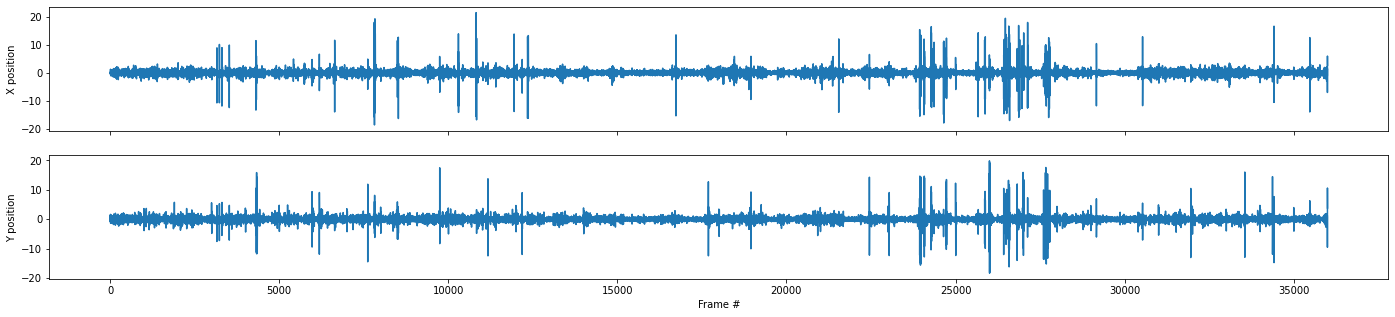

In [18]:
diff = kpts[:,0,:] - kpts_smooth_means[:,0,:]
plot_coords(diff[:, 0], diff[:,1])

(None, <AxesSubplot:xlabel='X position', ylabel='Y position'>)

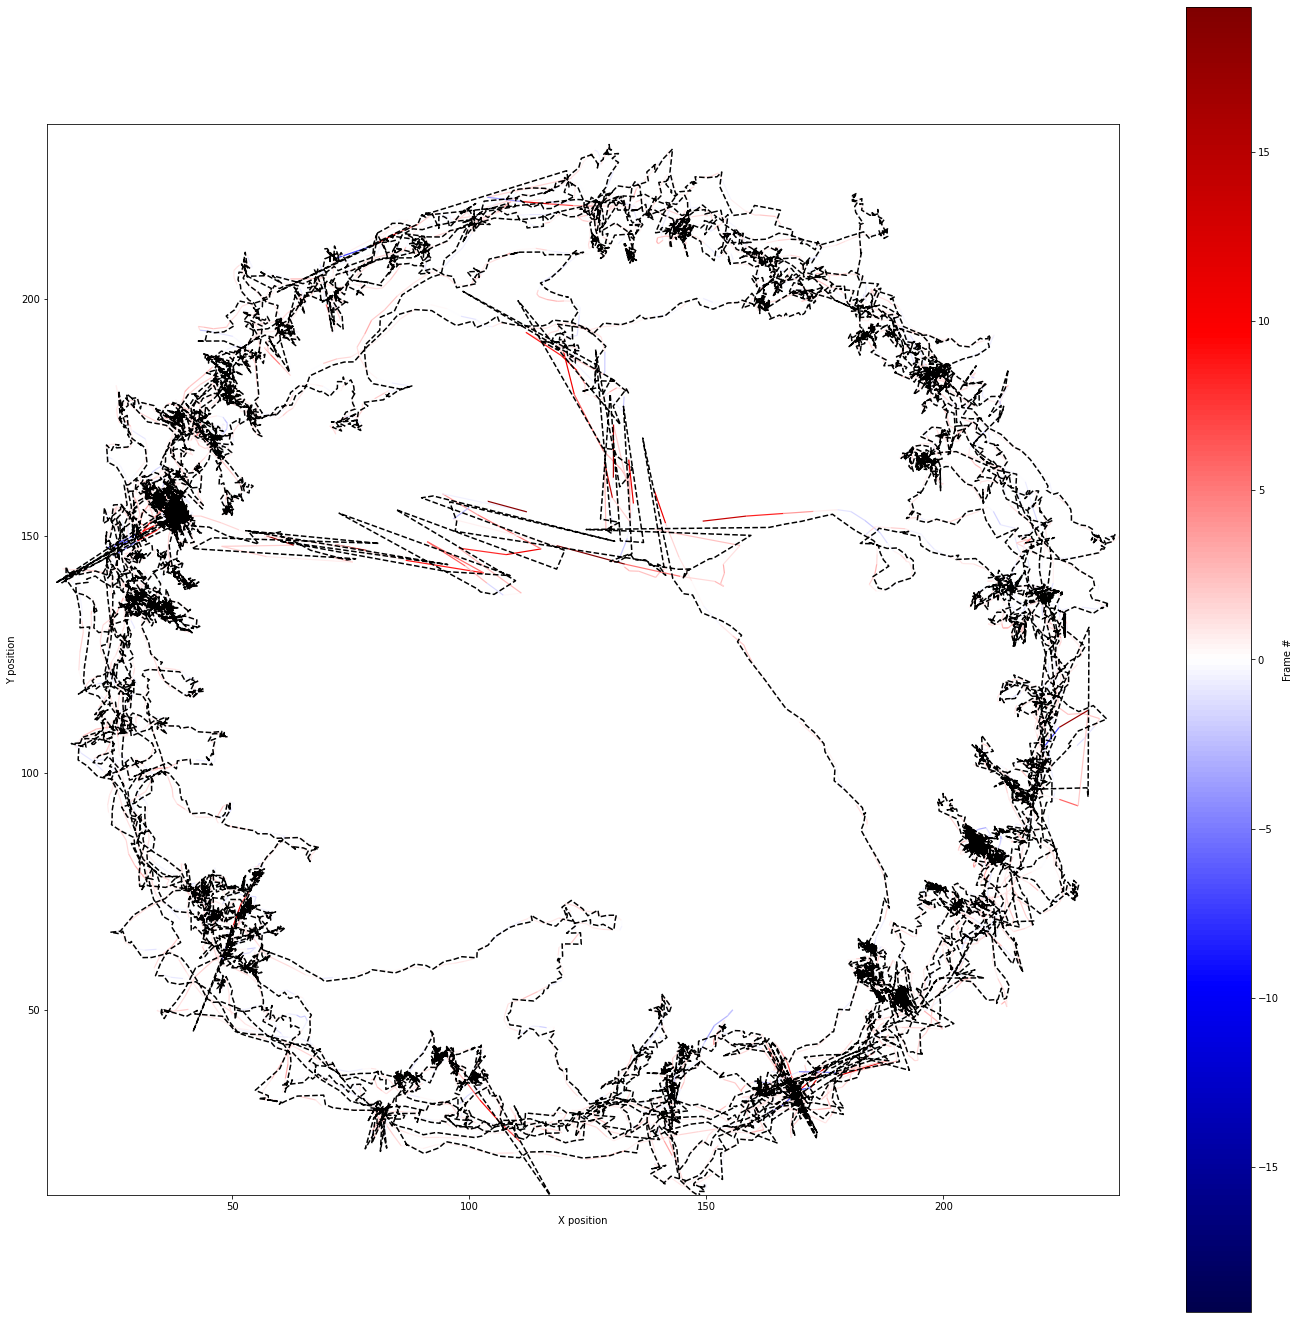

In [19]:
sm_kpts = kpts_smooth_means
ax=None
b = 0
e = 10000
fig, ax = plot_coords_2d(kpts[b:e,0,0], kpts[b:e,0,1], figsize=(24, 24), use_z=False)
plot_coords_2d(sm_kpts[b:e, 0, 0], sm_kpts[b:e, 0, 1], z=np.max(kpts[b:e,0,:]-sm_kpts[b:e, 0, :], axis=1), cmap="seismic", ax=ax, figsize=(24, 24))


In [7]:
adiff = angles - angles_smooth_means
plot_coords(angles, adiff)
#plt.plot(adiff)

NameError: name 'angles' is not defined

In [ ]:
pca = FastICA(n_components=8)
transformed = pca.fit_transform(kpkpdist.reshape(kpts.shape[0], -1))

sc = plt.scatter(transformed[:,0], transformed[:,1], c=np.abs(np.max(kpts[:,0,:]-sm_kpts[:, 0, :], axis=1)), s=2)
plt.colorbar(sc)

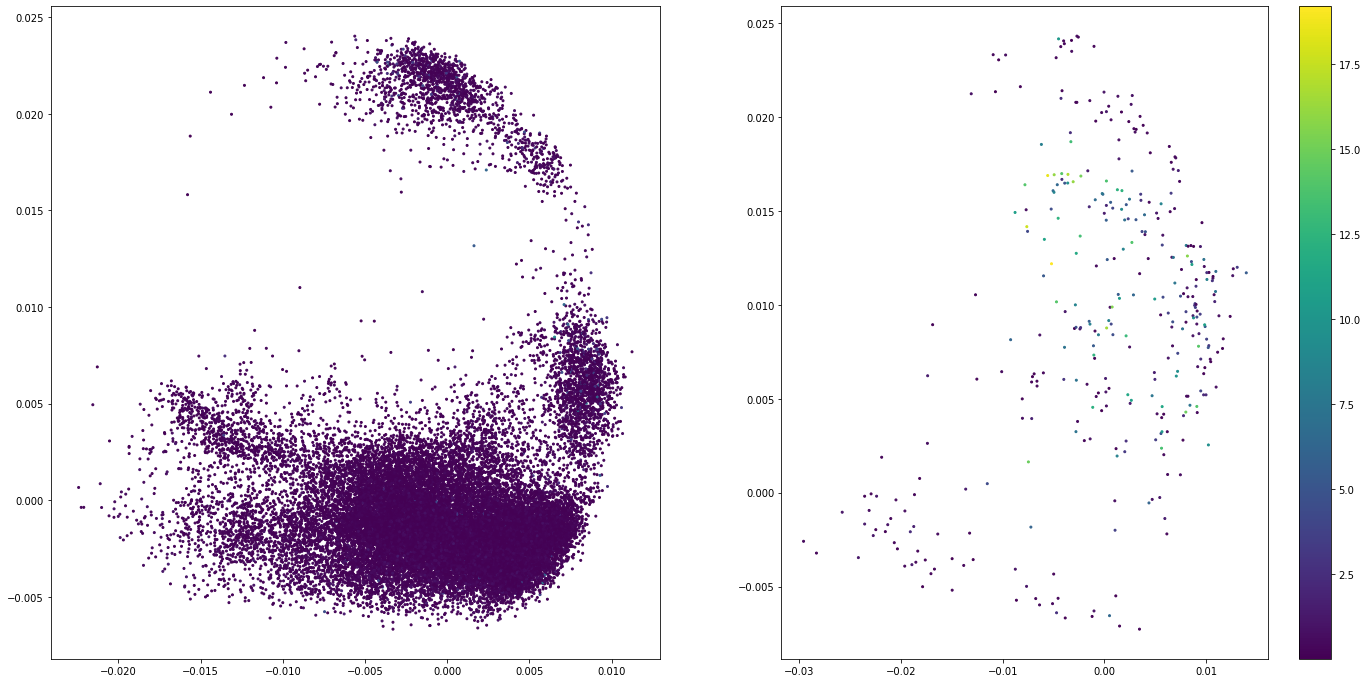

In [31]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(max_samples=1.0)
predictions = clf.fit_predict(kpkpdist.reshape(kpts.shape[0], -1))
outlier_fraction = (predictions==-1).nonzero()[0].shape[0]/(predictions==1).nonzero()[0].shape[0]
print("outlier fraction", outlier_fraction)

fig, axs = plt.subplots(1, 2, figsize=(24, 12))
colors = np.abs(np.max(kpts[:,0,:]-sm_kpts[:, 0, :], axis=1))
sc = axs[0].scatter(transformed[(predictions==1),0], transformed[(predictions==1),1], c=colors[(predictions==1)], s=4)
sc = axs[1].scatter(transformed[(predictions==-1),0], transformed[(predictions==-1),1], c=colors[((predictions==-1))], s=4)
plt.colorbar(sc)

c:\Users\thackray\.conda\envs\moseq-detectron\lib\site-packages\sklearn\covariance\_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


outlier fraction 0.005053042992741485


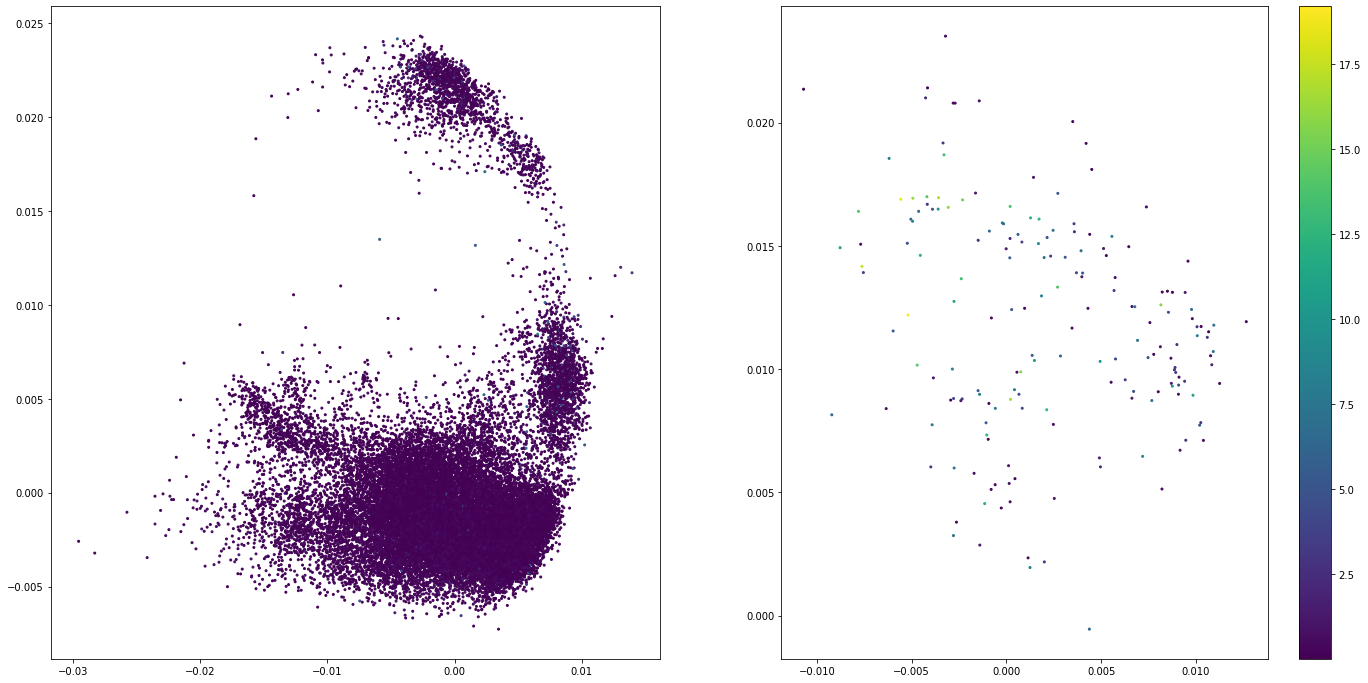

In [41]:
from sklearn.covariance import EllipticEnvelope
clf = EllipticEnvelope(contamination=0.005)
predictions = clf.fit_predict(kpkpdist.reshape(kpts.shape[0], -1))
outlier_fraction = (predictions==-1).nonzero()[0].shape[0]/(predictions==1).nonzero()[0].shape[0]
print("outlier fraction", outlier_fraction)

fig, axs = plt.subplots(1, 2, figsize=(24, 12))
colors = np.abs(np.max(kpts[:,0,:]-sm_kpts[:, 0, :], axis=1))
sc = axs[0].scatter(transformed[(predictions==1),0], transformed[(predictions==1),1], c=colors[(predictions==1)], s=4)
sc = axs[1].scatter(transformed[(predictions==-1),0], transformed[(predictions==-1),1], c=colors[((predictions==-1))], s=4)
plt.colorbar(sc)

In [42]:
kpkpdist.shape

(36001, 8, 8)

In [52]:
a = np.zeros((36, 8, 2))
b = np.ones((36, 2))
np.concatenate((b[:, None, :], a), axis=1)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 3 dimension(s)

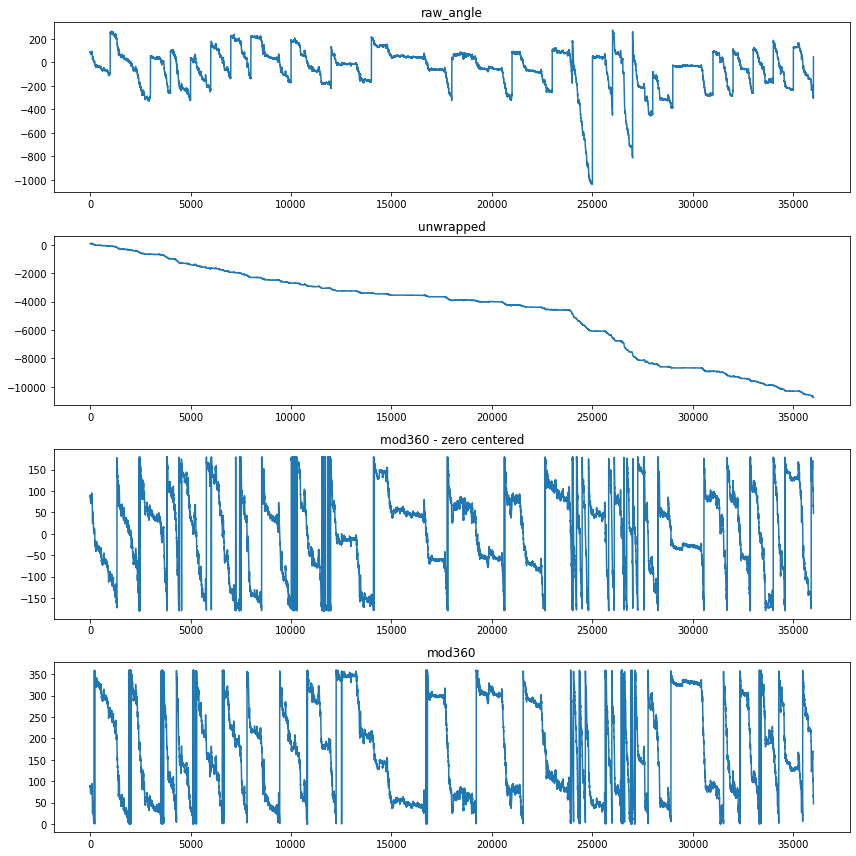

In [6]:
with h5py.File(dataset_path) as h5:
    fig, axs = plt.subplots(4, 1, figsize=(12, 12))

    axs[0].plot(h5['/scalars/angle'][()])
    axs[0].set_title("raw_angle")

    axs[1].plot(np.unwrap(h5['/scalars/angle'][()], period=360))
    axs[1].set_title("unwrapped")

    axs[2].plot(np.mod(h5['/scalars/angle'][()] + 180, 360) - 180)
    axs[2].set_title("mod360 - zero centered")

    axs[3].plot(np.mod(h5['/scalars/angle'][()], 360))
    axs[3].set_title("mod360")

    fig.tight_layout()


In [38]:
kf.kalman_filter


KalmanFilter object
dim_x = 57
dim_z = 19
dim_u = 0
x = [ 1.27998398e+02  2.99106645e+00  5.16911744e-01  1.11671349e+02
      1.27204326e+00  4.95658705e-01  1.25967504e+02  6.28633588e-01
     -3.76022885e-05  1.05507364e+02 -8.04830335e-01 -1.26092753e-01
      1.20304189e+02  1.31950801e+00  2.14249533e-01  1.09931917e+02
     -4.17443461e-01 -1.16986010e-01  1.20525052e+02  5.68531863e-01
      2.42639279e-02  1.05260082e+02 -4.40372165e-01 -1.15230012e-01
      1.13262514e+02  2.54323893e-02  4.76453734e-02  9.13198212e+01
     -4.32129912e-01 -1.60250238e-01  1.08404315e+02  3.36831340e-01
      1.04854328e-01  9.43858053e+01 -1.16571734e-01 -1.17336853e-01
      1.08444019e+02 -2.31104978e-01 -7.39280889e-03  8.88778936e+01
     -1.68553416e-01 -1.53764467e-01  1.34310356e+02  5.32177497e+00
      6.44182334e-01  1.20900876e+02  9.99890137e-01 -2.64114009e-01
      1.15931655e+02  4.54337594e-01  3.96906972e-02  1.15931655e+02
      4.54337594e-01  3.96906971e-02 -1.07511143e+0